In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

In [ ]:
# Load the data
file_path = Path('Diabetes dataset_Group12.csv')
df = pd.read_csv(file_path)
df = df.drop(columns = "ID")
new_df = df.drop(columns = "Label")
new_df.head()

In [5]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['Label'] = df['Label'].astype(str)
df['Label'] = encoder.fit_transform(df['Label'])

<AxesSubplot:>

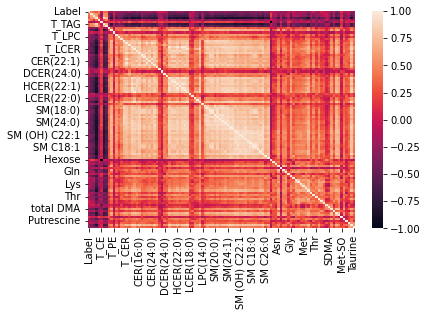

In [6]:
#heatmap of correlation
sns.heatmap(df.corr())

In [7]:
def get_high_corr_df(df, positive_threshold=0.3):
    corr = df.corr().stack().reset_index().drop_duplicates()
    corr.columns = ['FEATURE_1', 'FEATURE_2', 'CORRELATION']
    high_corr = corr[((corr['FEATURE_1'] != corr['FEATURE_2']) & ((corr['CORRELATION'] >= positive_threshold) | (corr['CORRELATION'] <= positive_threshold*-1)))]
    return high_corr

In [8]:
high_corr = get_high_corr_df(df)
high_corr[(high_corr['FEATURE_1'] == 'Label')]

,FEATURE_1,FEATURE_2,CORRELATION
1,Label,FPG,0.434875
2,Label,HOMA_IR,0.355802
4,Label,2hr_OGTT,0.542159
6,Label,T_TAG,0.380311
7,Label,T_DAG,0.339518
17,Label,T_HCER,-0.364128
18,Label,T_LCER,-0.395266
20,Label,CER(16:0),-0.346938
26,Label,CER(24:1),-0.355125
32,Label,HCER(16:0),-0.413360


In [25]:
# Create our features
X = df[high_corr['FEATURE_2'].unique()]

# Create our target
y = df["Label"]

In [26]:
X.describe()

,FPG,HOMA_IR,2hr_OGTT,T_TAG,T_DAG,T_HCER,T_LCER,CER(16:0),CER(24:1),HCER(16:0),...,SDMA,DCER(22:0),LCER(18:1),Glu,Met-SO,Serotonin,T_CE,DCER(22:1),LCER(18:0),Ala
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,...,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,6.614549,2.701736,6.926155,10.319602,4.323889,1.110375,1.537681,-1.609484,-0.317968,-0.639560,...,-0.911963,-2.968373,-2.923861,5.835851,-3.658187,-2.809970,12.133278,-3.502753,-3.617123,8.440780
std,0.139946,0.923355,0.336438,0.613956,0.329148,0.664391,0.777931,0.553841,0.541759,0.656985,...,2.262527,0.847986,1.386213,0.613893,2.969190,2.188667,0.128341,1.477919,2.009777,0.477065
min,6.339851,0.706960,5.882646,9.004653,3.531287,-0.729749,-0.588614,-3.108861,-1.837912,-2.533307,...,-10.044283,-6.764864,-8.606643,4.234467,-10.044284,-10.044283,12.098650,-8.606643,-9.285779,7.322323
25%,6.515637,2.153218,6.703892,10.273816,4.090292,0.737191,1.109688,-1.980622,-0.624027,-0.925477,...,-1.004203,-3.269135,-3.240680,5.427835,-5.841102,-3.881660,12.098650,-3.552731,-3.762843,8.130496
50%,6.607312,2.538648,6.906891,10.273816,4.331543,1.158802,1.743218,-1.544676,-0.238619,-0.573323,...,-0.263703,-2.936694,-2.538021,5.913836,-2.782335,-2.407604,12.098650,-3.114947,-2.942149,8.422520
75%,6.700441,3.319494,7.199572,10.673808,4.568362,1.653154,2.138187,-1.129873,0.033986,-0.091106,...,0.196751,-2.412828,-2.094270,6.201496,-1.191318,-1.466755,12.098650,-2.657965,-2.415242,8.710862
max,6.965785,5.093344,7.507795,11.408379,4.907486,2.079468,2.938209,-0.660292,0.543915,0.312606,...,2.898183,-1.739427,-1.344333,7.243204,1.045463,0.972990,12.600750,-1.491908,-1.651307,9.443437


In [11]:
# Check the balance of our target values
y.value_counts()

1    30
0    28
Name: Label, dtype: int64

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [13]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
randomforest = BalancedRandomForestClassifier(n_estimators = 100, max_depth= 7, max_features='auto', random_state=1)
resampled = randomforest.fit(X_train, y_train)

In [14]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
yprediction = resampled.predict(X_test)
balanced_accuracy_score(y_test, yprediction)

0.6071428571428572

In [15]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, yprediction)
print(matrix)

[[5 2]
 [4 4]]


In [16]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
report = classification_report_imbalanced(y_test, yprediction)
print(report)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.56      0.71      0.50      0.63      0.60      0.36         7
          1       0.67      0.50      0.71      0.57      0.60      0.35         8

avg / total       0.61      0.60      0.61      0.60      0.60      0.36        15



In [17]:
# List the features sorted in descending order by feature importance
feature_names = X.columns.drop('Label')
sorted(zip(randomforest.feature_importances_, feature_names), reverse=True)

[(0.16698577418451788, 'Total_TAG'),
 (0.04120047038409429, '2hr_OGTT'),
 (0.03272443902006566, 'HCER(18:0)'),
 (0.0319053148455437, 'SM C16:0'),
 (0.03001008259820938, 'SM C24:1'),
 (0.026565178230894004, 'SM C18:0'),
 (0.024404408878984308, 'SM(20:1)'),
 (0.021655023458493086, 'HCER(20:0)'),
 (0.021236570794554724, 'CER(24:1)'),
 (0.020483099700025695, 'Kynurenine'),
 (0.019604030222750483, 'SM (OH) C22:2'),
 (0.01812834978470728, 'LCER(24:0)'),
 (0.016750471330009713, 'SM(24:1)'),
 (0.01664996924694561, 'Lys'),
 (0.015444028750597603, 'T_DAG'),
 (0.015224217781200857, 'HCER(24:1)'),
 (0.01494916287254636, 'CER(26:0)'),
 (0.014177680731785523, 'His'),
 (0.014149015342569196, 'LCER(22:0)'),
 (0.013673898206640736, 'FPG'),
 (0.012836579652655167, 'HCER(22:0)'),
 (0.012835884782270556, 'SM C20:2'),
 (0.01140887838466023, 'SM C24:0'),
 (0.011081045011110104, 'CER(18:0)'),
 (0.011002279556715552, 'SM C18:1'),
 (0.010968221302112134, 'Serotonin'),
 (0.010673798816385303, 'SM (OH) C16:1'),


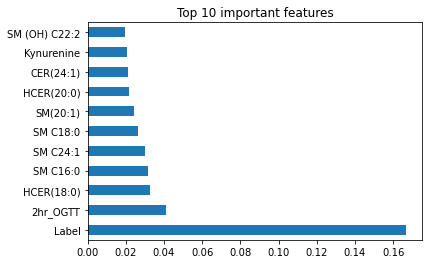

In [23]:
feat_importances = pd.Series(randomforest.feature_importances_, index = X.columns)
feat_importances.nlargest(11).plot(kind='barh')
plt.title("Top 10 important features")
plt.show()

In [30]:
def find_top_10_feature(df):
    feat = []
    feat_name = X.columns
    feat_importances = pd.Series(randomforest.feature_importances_, index=X.columns)
    for f in feat_importances.nlargest(11).keys():
        feat.append(f)
    new_df = df[feat]
    return new_df

In [31]:
top_10_parameters = find_top_10_feature(df)
top_10_parameters

,Label,2hr_OGTT,HCER(18:0),SM C16:0,SM C24:1,SM C18:0,SM(20:1),HCER(20:0),CER(24:1),Kynurenine,SM (OH) C22:2
0,0,6.491854,-2.419750,7.118906,5.857852,5.017517,3.311127,-2.473015,0.330745,2.394366,3.965879
1,0,7.451211,-4.759624,6.666040,5.553419,4.424867,2.616889,-5.221904,-0.543613,0.756260,3.965879
2,0,6.942515,-4.411737,6.849232,5.511664,4.746527,3.067994,-3.905027,-0.588614,1.285267,3.737528
3,0,6.629358,-4.014523,6.900866,5.780461,4.784064,2.863653,-3.384574,-0.373590,2.198089,3.691855
4,0,6.954197,-3.462398,7.835243,6.141387,5.390962,3.260484,-2.718640,-0.125426,2.766317,4.331543
5,0,7.011228,-4.411737,6.572109,5.265775,4.069262,2.616889,-3.867854,0.039896,1.874979,3.260484
6,0,5.882646,-4.453161,7.199930,5.972735,4.807594,3.029029,-3.769828,-0.014012,2.333384,4.102666
7,0,6.409392,-3.614449,6.900866,5.706836,4.886812,3.051256,-3.145012,0.016257,2.297289,3.496043
8,0,6.906891,-3.769828,7.199930,5.629423,4.530147,2.878295,-3.313604,-0.067494,1.528768,3.260484
9,0,6.741468,-3.666074,6.996657,5.894638,4.856116,2.938209,-3.384574,0.163249,2.480864,4.019548


In [32]:
#top_10_parameters.to_csv('top_10_parameters.csv')